In [ ]:
# https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!nvidia-smi

Thu Aug 19 04:11:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 50.3 MB/s 
     |████████████████████████████████| 3.3 MB 69.3 MB/s 
     |████████████████████████████████| 636 kB 84.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install pytorch-lightning

     |████████████████████████████████| 916 kB 4.1 MB/s 
     |████████████████████████████████| 272 kB 71.6 MB/s 
     |████████████████████████████████| 829 kB 87.4 MB/s 
     |████████████████████████████████| 118 kB 65.9 MB/s 
     |████████████████████████████████| 1.3 MB 58.7 MB/s 
     |████████████████████████████████| 142 kB 88.1 MB/s 
     |████████████████████████████████| 294 kB 98.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=e90014da1dcf8520241de19fe512d213e23e81f515a761cf548547321880d727
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline  
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [ ]:
# import dataset
df = pd.read_csv('drive/MyDrive/Biocreative/Biocreative/datasets/preprocessed_version3.csv')
df = df.dropna()
df.head()

,abstract,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,December 2019 several novel coronavirus infect...,0,0,0,0,1,0,0
1,report describes case Bacillus cereus bacterem...,1,0,0,0,0,0,0
2,context COVID-19 pandemic patient need evaluat...,0,0,0,0,1,0,0
3,novel coronavirus severe acute respiratory syn...,0,0,0,0,0,0,1
4,SUMMARY iBioProVis interactive tool visual ana...,0,0,0,1,0,0,1


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.1)
train_df.shape, val_df.shape

((28074, 8), (3120, 8))

In [ ]:
LABEL_COLUMNS = df.columns.tolist()[1:]

In [ ]:
print(LABEL_COLUMNS)

['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism', 'Prevention', 'Transmission', 'Treatment']


In [ ]:
df[LABEL_COLUMNS].sum().sort_values()

Epidemic Forecasting      837
Transmission             1344
Case Report              2545
Mechanism                5510
Diagnosis                7739
Treatment               10923
Prevention              13849
dtype: int64

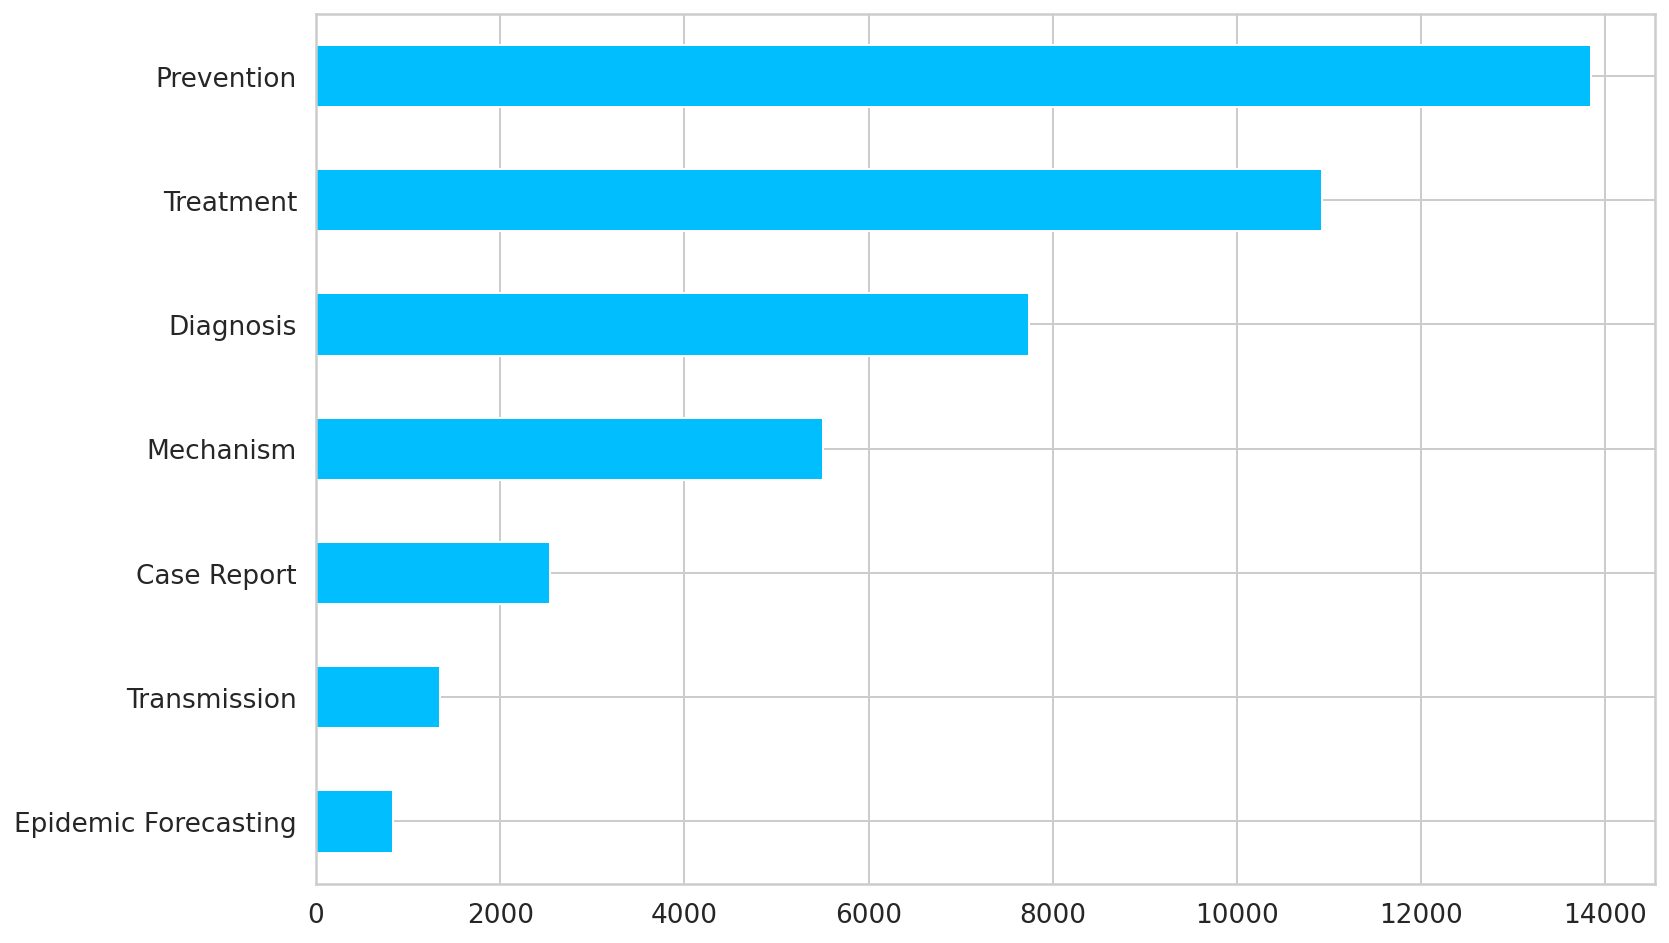

In [ ]:
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

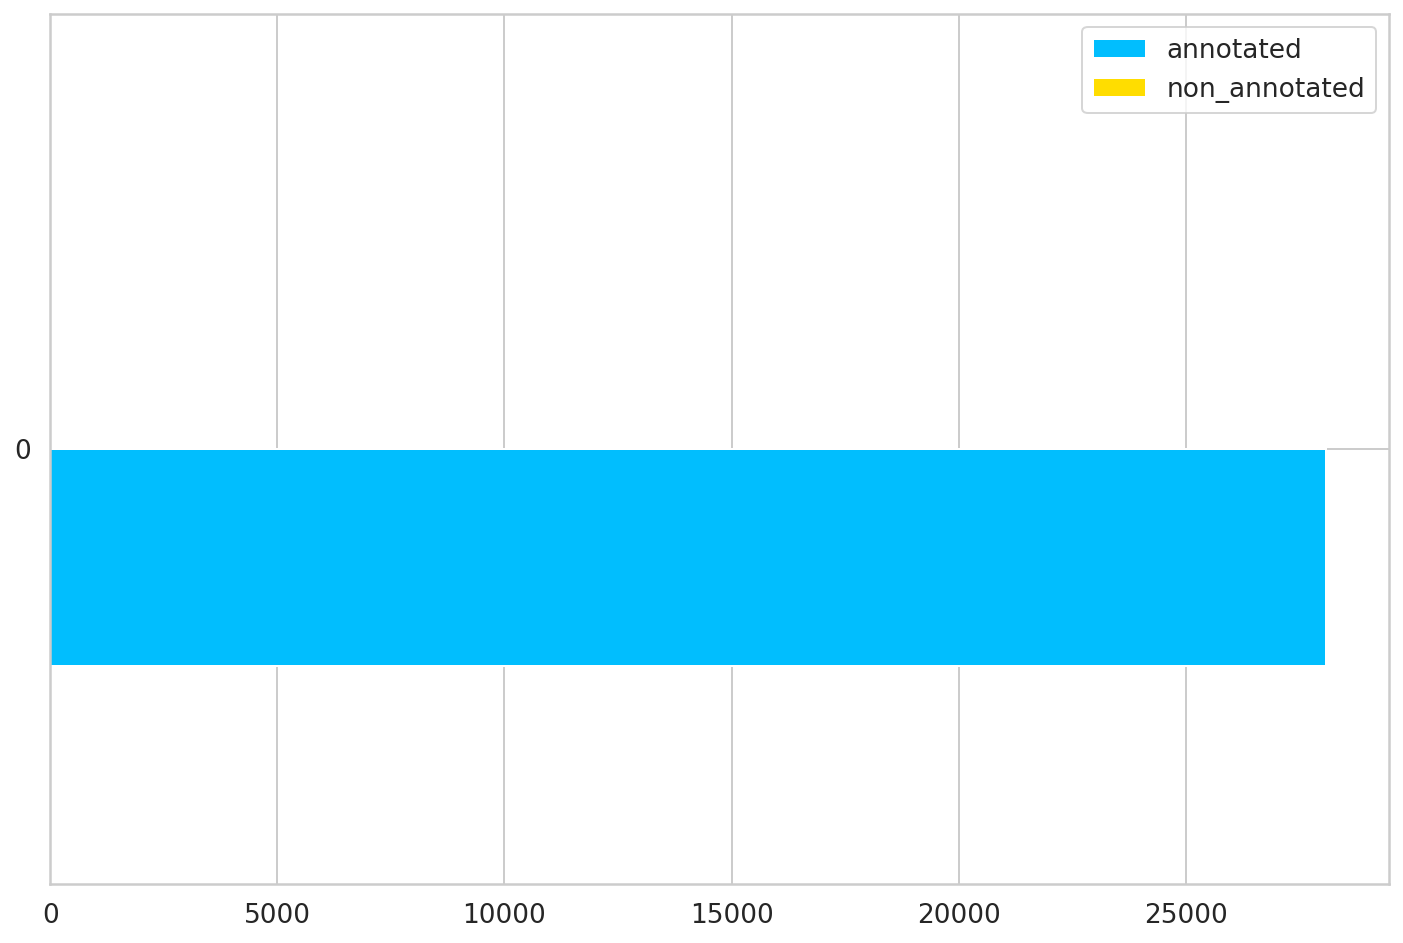

In [ ]:
annotated = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
non_annotated = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  annotated=[len(annotated)],
  non_annotated=[len(non_annotated)]
)).plot(kind='barh');

In [ ]:
# BERT_MODEL_NAME = 'dmis-lab/biobert-base-cased-v1.1'
# Ref : microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
BERT_MODEL_NAME = input("Enter Bert Model Name: ")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

Enter Bert Model Name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext


Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

#### tokenization example

In [ ]:
abstract = "Sir Italy recently involved outbreak severe interstitial pneumonia associated previously unknown Coronavirus SARS-CoV-2 1,2 . Even notification first autochthonous case SARS-CoV-2 associated syndrome COVID-19 raised intense attention public opinion 3 , counterproductive over-abundance mixed quality information even Italian healthcare worker HCWs spared subsequent misunderstanding knowledge gap previous influenza pandemic 2009 4 , performed web-based survey Google R Modules , specifically aimed characterize knowledge status risk perception sample participating 6 Facebook discussion group 181,684 total unique member time study . questionnaire made available February 1st 7th 2020 i.e around 2 week first COVID-19 officially diagnosed Italian resident Overall sampled population included 2106 respondent Table 1 , 39.3 HCWs Even though HCWs likely exhibit better understanding SARS-CoV-2/COVID-19 related issue aOR 2.195 95 CI 1.809 2.664 , exempt misunderstanding particularly actual incidence lethality COVID-19 Interestingly respondent aware main clinical feature COVID-19 HCWs frequently acknowledging COVID-19 may run pauci- even asymptomatic 86.3 vs. 79.1 ) resembling Influenza-Like Illness i.e fever cough headache etc ) potential latency 14 day 85.9 vs. 80.3 ) eventually spreading droplet 98.5 vs. 92.7 ) rather running water 92.3 vs. 79.8 ) blood/body fluid 88.0 vs. 70.4 ) Retrospectively assessment preventive measure risk perception appears somewhat worrisome instance HCWs likely acknowledge appropriate preventive measure wearing filtering mask i.e N95/FFP2/3 mask aOR 2.296 95 CI 1.507 3.946 , around 1/4 HCWs failed recognize importance personal protective equipment 7.4 felt appropriate wearing surgical mask Moreover COVID-19 appropriately acknowledged severe disease 62.0 respondent difference HCWs non-HCWs even smaller share i.e 8.0 ) reported concern infected SARS-CoV-2 Italy fact time survey SARS-CoV-2 properly associated international traveler 26.7 ) result therefore certain interest several reason First early epidemiological report Italian case COVID-19 hint towards failure initial management incident case 5-6 . fact survey large share respondent substantially overlooked risk interact SARS-CoV-2 positive subject otherwise perceived not-so-severe disease i.e `` nothing seasonal flu '' often described social medium ( 7 . Moreover around 1/3 HCWs participating study presumptively use proper personal protective equipment airway interacting possible COVID-19 case either underestimating infection risk unable recognize early symptom Actually base evidence shared participant time study substantially ignored COVID-19 may characterized dermatologic gastro-intestinal symptom 8-9 . infection may actually pauci- asymptomatic early exposure healthcare setting may contributed quick spreading SARS-CoV-2 epidemic Northern Italy Therefore despite intrinsic limit convenience sampling web-based survey 10 , study stress importance improve overall quality information COVID-19 conveyed HCWs also general population Moreover data may contribute clarify early stage SARS-CoV-2 pandemic Italy"
encoding = tokenizer.encode_plus(
    abstract,
    return_tensors = "pt"
)
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].flatten()))

['[CLS]', 'sir', 'italy', 'recently', 'involved', 'outbreak', 'severe', 'interstitial', 'pneumonia', 'associated', 'previously', 'unknown', 'coron', '##avirus', 'sars', '-', 'cov', '-', '2', '1', ',', '2', '.', 'even', 'notification', 'first', 'autoc', '##ht', '##ho', '##no', '##us', 'case', 'sars', '-', 'cov', '-', '2', 'associated', 'syndrome', 'cov', '##id', '-', '19', 'raised', 'intense', 'attention', 'public', 'opinion', '3', ',', 'counter', '##produc', '##tive', 'over', '-', 'abundance', 'mixed', 'quality', 'information', 'even', 'italian', 'healthcare', 'worker', 'hc', '##ws', 'spared', 'subsequent', 'mis', '##unders', '##tanding', 'knowledge', 'gap', 'previous', 'influenza', 'pandemic', '2009', '4', ',', 'performed', 'web', '-', 'based', 'survey', 'google', 'r', 'modules', ',', 'specifically', 'aimed', 'characterize', 'knowledge', 'status', 'risk', 'perception', 'sample', 'participating', '6', 'facebook', 'discussion', 'group', '181', ',', '68', '##4', 'total', 'unique', 'membe

#### continued data analysis

(0.0, 512.0)

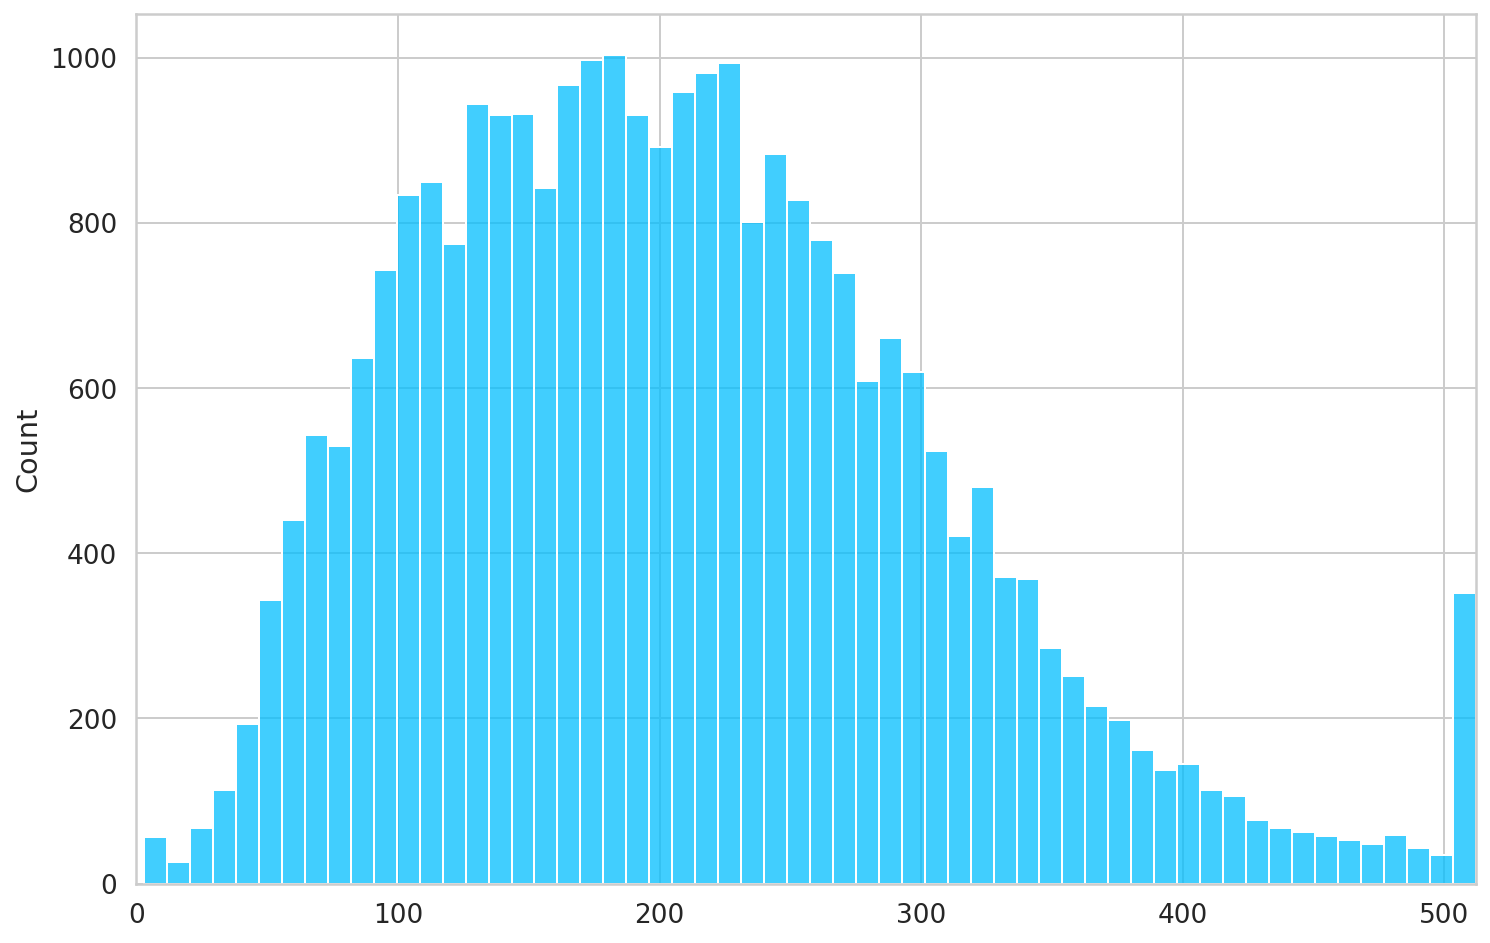

In [ ]:
token_counts = []
data = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
      row["abstract"],
      max_length=512,
      truncation=True
  ))

  if token_count > 512:
    data.append([row["abstract"], row[LABEL_COLUMNS]])
  token_counts.append(token_count)

sns.histplot(token_counts)
plt.xlim([0, 512])

In [ ]:
# data

(0.0, 7079.0)

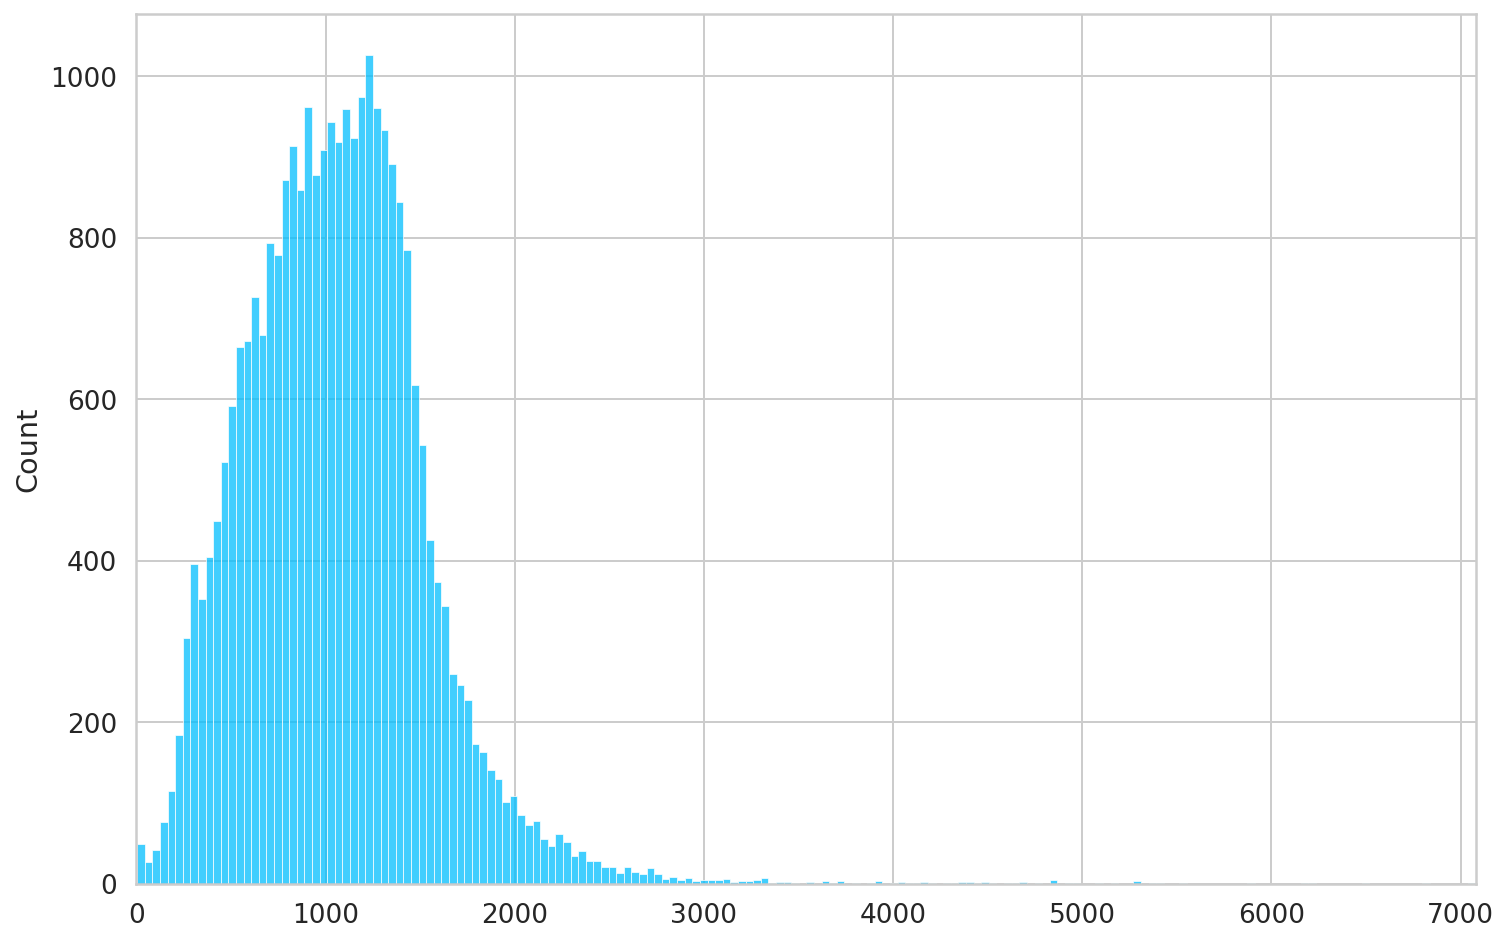

In [ ]:
char_lengths = []

for _, row in train_df.iterrows():
  char_lengths.append(len(row["abstract"]))

sns.histplot(char_lengths)
plt.xlim([0, max(char_lengths)])

(0.0, 908.0)

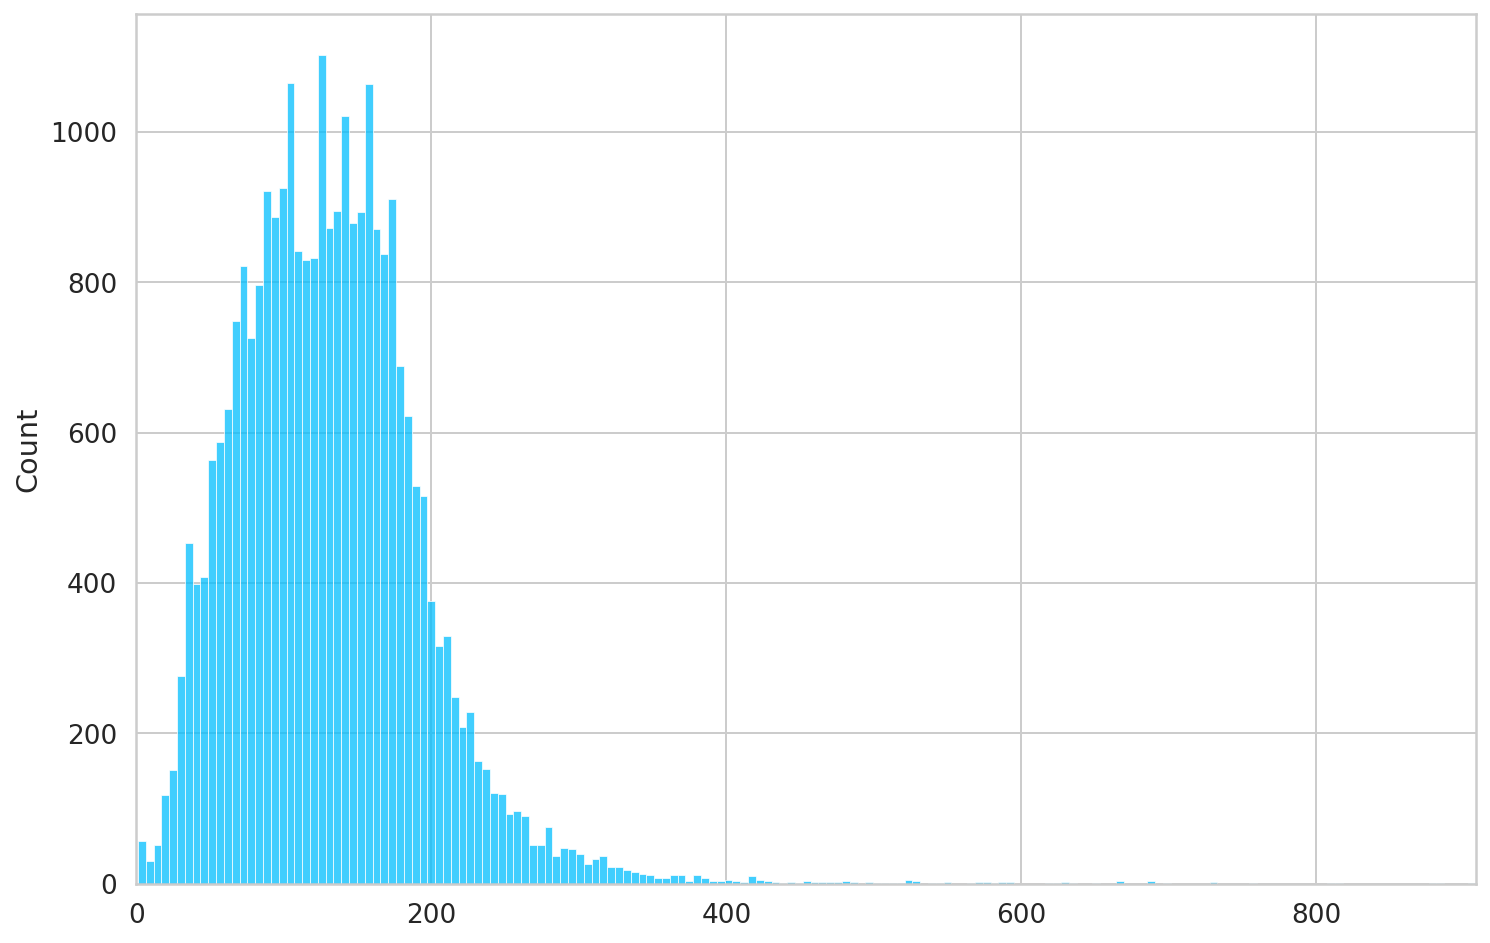

In [ ]:
word_lengths = []

for _, row in train_df.iterrows():
  word_lengths.append(len(row["abstract"].split(' ')))

sns.histplot(word_lengths)
plt.xlim([0, max(word_lengths)])

### continuation

In [ ]:
MAX_TOKEN_COUNT = 512

In [ ]:
class TopicAnnotationDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: AutoTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index=int):
    
    data_row = self.data.iloc[index]

    abstract_text = data_row.abstract
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
        abstract_text,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    return dict(
        abstract_text=abstract_text,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        labels=torch.FloatTensor(labels) 
    )  

In [ ]:
train_dataset = TopicAnnotationDataset(
    train_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

### cells to avoid during final run.

In [ ]:
# instantiating a bert model
bert_model = AutoModel.from_pretrained(BERT_MODEL_NAME)

sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch.keys()

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


dict_keys(['abstract_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [ ]:
# output dimensions from bert model
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 512, 768]), torch.Size([8, 768]))

In [ ]:
# modification for attention
# we're using pooler_output as bert encodings which are then mapped to 7 classes
# after which we compute BCELoss with target labels 
# e.g. (b, 768) -> (b, 7) compared with target (b, 7)


# usual attention 
# we'll be using last_hidden_state output which is (b, n, 768)
# energy layer will map output to (b, n, 1)
# after which a relu layer will be adopted
# calculate the attention => softmax(energy) (b, n, 1)
# Now Attention is (b, n, 1)
# hidden output is (b, n, 768)
# context vector should be (b, 1, 768) -> reshaped to (b, 1) and compared with target lables.

# usual attention 
# we'll be using last_hidden_state output which is (b, n, 768)
# energy layer will map output to (b, n, 7)
# after which a relu layer will be adopted
# calculate the attention => softmax(energy) (b, n, 7)
# Now Attention is (b, n, 7)
# hidden output is (b, n, 768)
# context vector should be (b, 7, 768) -> reshaped to (b, 7) and compared with target lables.

In [ ]:
num_labels = 7
encoded_output = output.last_hidden_state
(batch_size, sequence_length, hidden_size) = encoded_output.shape

# under __init__ section
# fully-connected layer (B, N, H) -> 
fc = nn.Linear(hidden_size, num_labels)
relu = nn.ReLU()
softmax = nn.Softmax(dim=1)
classifier = nn.Linear(hidden_size, 1)
sigmoid = nn.Sigmoid()

# under forward section
energy = relu(fc(encoded_output))
print(energy.shape)
attention = softmax(energy)
print(attention.shape)
context_vector = torch.einsum("nsk,nsl->nkl", attention, encoded_output)
print(context_vector.shape)
final_output = sigmoid(classifier(context_vector).squeeze(-1))
print(final_output.shape)

torch.Size([8, 512, 7])
torch.Size([8, 512, 7])
torch.Size([8, 7, 768])
torch.Size([8, 7])


In [ ]:
criterion = nn.BCELoss()

In [ ]:
truth_label = sample_batch["labels"]
truth_label.shape

torch.Size([8, 7])

In [ ]:
criterion(final_output, truth_label)

tensor(0.6278, grad_fn=<BinaryCrossEntropyBackward>)

In [ ]:
# size of last hidden layer.
bert_model.config.hidden_size

768

### continutation

In [ ]:
class TopicAnnotationDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    
    self.train_dataset =  TopicAnnotationDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )

    self.test_dataset = TopicAnnotationDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):

    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):

    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 16

data_module = TopicAnnotationDataModule(
    train_df,
    val_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
# #PyTorch
# class DiceLoss(nn.Module):

#   def __init__(self, weight=None, size_average=True):
    
#     super(DiceLoss, self).__init__()

#   def forward(self, inputs, targets, smooth=1):
      
#     #comment out if your model contains a sigmoid or equivalent activation layer
#     inputs = F.sigmoid(inputs)       
    
#     #flatten label and prediction tensors
#     inputs = inputs.view(-1)
#     targets = targets.view(-1)
    
#     intersection = (inputs * targets).sum()                            
#     dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
    
#     return 1 - dice

In [ ]:
Label_count = df[LABEL_COLUMNS].sum().to_dict()
count = list(Label_count.values())
max_val = max(count)
class_weight = [max_val/val for val in count]
class_weight

[5.4416502946954814,
 1.7895076883318257,
 16.54599761051374,
 2.513430127041742,
 1.0,
 10.304315476190476,
 1.2678751258811682]

In [ ]:
# dict(zip(LABEL_COLUMNS, class_weight))
class_weight = torch.tensor(class_weight, device="cuda")

In [ ]:
class WeightedMultilabel(nn.Module):

  def __init__(self, weights: torch.Tensor):
    
    super(WeightedMultilabel, self).__init__()  
    self.criterion = nn.BCELoss(reduction='none')  
    self.weights = weights 

  def forward(self, outputs, targets):

    loss = self.criterion(outputs, targets)
    return (loss * self.weights).mean()

In [ ]:
class TopicAnnotationTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    
    super().__init__()
    self.bert = AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    # self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss(weight=class_weight)
    # self.criterion = DiceLoss()

    # using weighted loss
    # self.criterion = WeightedMultilabel(class_weight)

    # pos_weight = torch.ones([7])
    # self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)
    self.classifier = nn.Linear(self.bert.config.hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask, labels=None):

    bert_outputs = self.bert(input_ids, attention_mask=attention_mask)
    # last_hidden_state (batch_size x sequence_length x hidden_size)
    encoded_output = bert_outputs.last_hidden_state

    # linear transformation and apply relu 
    # (batch_size x sequence_length x hidden_size) => (batch_size, sequence_length x n_classes)
    energy = self.relu(self.fc(encoded_output))
    
    # calculate attention weights 
    # (batch_size x sequence_length x n_classes)
    attention = self.softmax(energy)

    # apply attention weigths to encoded_output 
    # (batch_size x sequence_length x n_classes) * (batch_size x sequence_length x hidden_size) => (batch_size x n_classes x hidden_size)
    context_vector = torch.einsum("nsk,nsl->nkl", attention, encoded_output)
    # apply sigmoid function to context vector
    output = self.sigmoid(self.classifier(context_vector).squeeze(-1))
    # output = self.classifier(output.pooler_output)
    # output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):

    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
            )
        )

### optimizer scheduler
- dummy model 

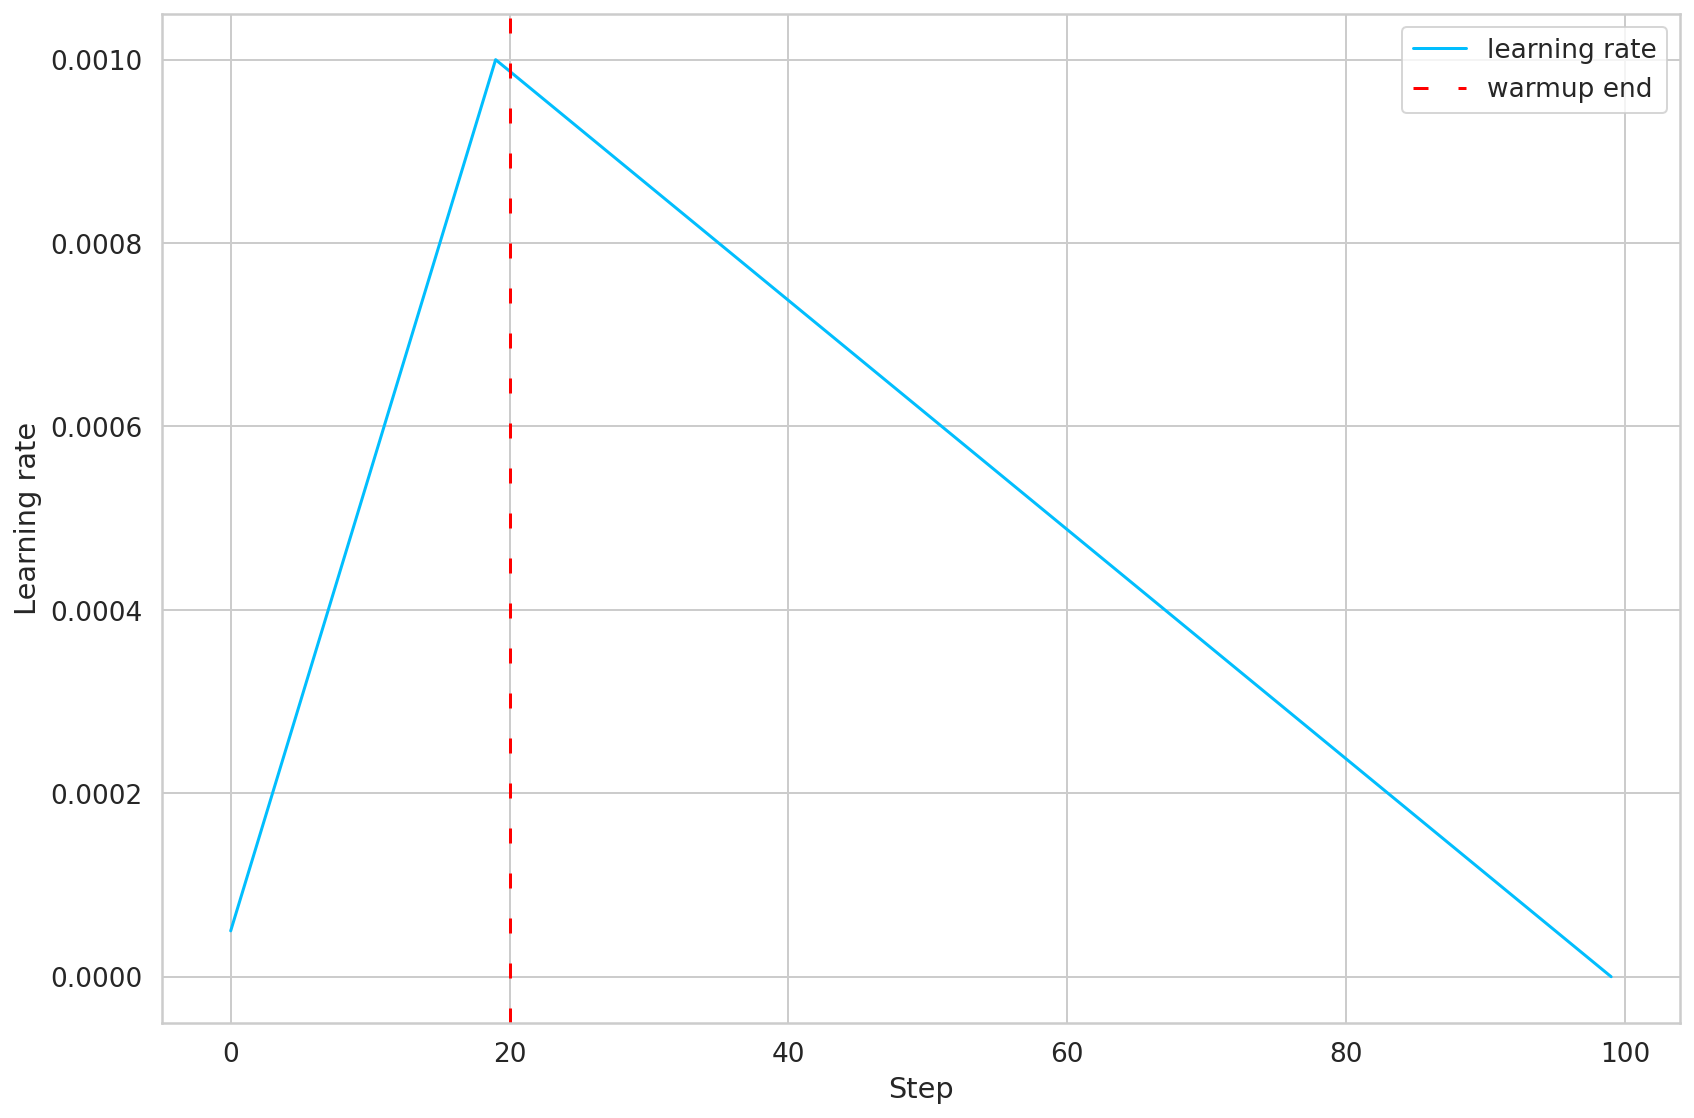

In [ ]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):

  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

### continuation

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(3508, 17540)

In [ ]:
model = TopicAnnotationTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Evaluation

In [ ]:
criterion = nn.BCELoss()
prediction = torch.FloatTensor(
    [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)

labels = torch.FloatTensor(
    [1., 0., 0., 0., 1., 0.]
)

torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [ ]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8725)

In [ ]:
# same approach as above can be applied to the model
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.5482, 0.5086, 0.3149, 0.3649, 0.4308, 0.5490, 0.4492],
        [0.4947, 0.5273, 0.4164, 0.3910, 0.3953, 0.5708, 0.4941],
        [0.5665, 0.5100, 0.3335, 0.3716, 0.4414, 0.5355, 0.4089],
        [0.5438, 0.5232, 0.3092, 0.3729, 0.4299, 0.5572, 0.4375],
        [0.5496, 0.5269, 0.3175, 0.3602, 0.4343, 0.5449, 0.4427],
        [0.5530, 0.5127, 0.3081, 0.3693, 0.4319, 0.5485, 0.4441],
        [0.5334, 0.5166, 0.3122, 0.3651, 0.4315, 0.5499, 0.4579],
        [0.4838, 0.5611, 0.4841, 0.4175, 0.4116, 0.5799, 0.4936]],
       grad_fn=<SigmoidBackward>)

In [ ]:
criterion(torch.sigmoid(predictions), sample_batch["labels"])

tensor(0.8342, grad_fn=<BinaryCrossEntropyBackward>)

### ROC Curve

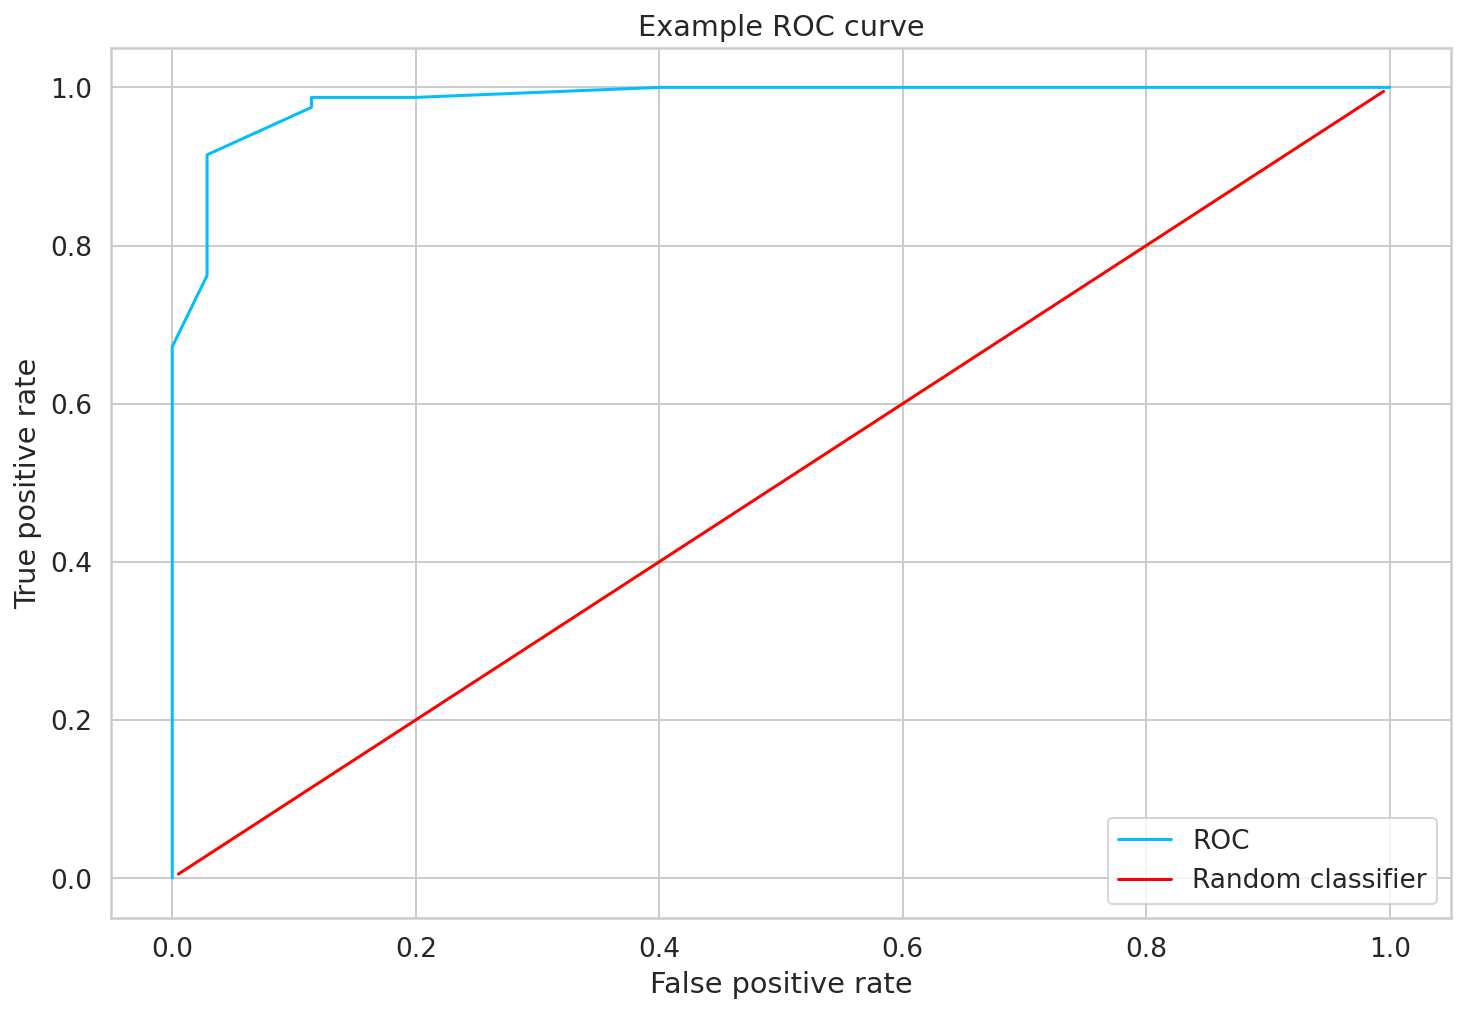

In [ ]:
from sklearn import metrics

fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]
tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]

_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

### continuation

In [ ]:
%pwd

'/content'

In [ ]:
cd '/content/drive/MyDrive/Biocreative/Biocreative'

/content/drive/MyDrive/Biocreative/Biocreative


In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="pubmednlp-lwan-checkpoints",
    filename="pubmednlp-lwan-best-checkpoint-(BCELoss&weight)",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

In [ ]:
logger = TensorBoardLogger("pubmednlp-lwan-lightning_logs", name="topic-annotations-(BCELoss&weight)")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=True,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | criterion  | BCELoss   | 0     
2 | fc         | Linear    | 5.4 K 
3 | relu       | ReLU      | 0     
4 | softmax    | Softmax   | 0     
5 | classifier | Line

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:398: LightningDeprecationWarning: One of the returned values {'labels', 'predictions'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
Epoch 0, global step 1754: val_loss reached 0.55632 (best 0.55632), saving model to "/content/drive/My Drive/Biocreative/Biocreative/pubmednlp-lwan-checkpoints/pubmednlp-lwan-best-checkpoint-(BCELoss&weight).ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 3509: val_loss reached 0.39635 (best 0.39635), saving model to "/content/drive/My Drive/Biocreative/Biocreative/pubmednlp-lwan-checkpoints/pubmednlp-lwan-best-checkpoint-(BCELoss&weight).ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 5264: val_loss reached 0.36734 (best 0.36734), saving model to "/content/drive/My Drive/Biocreative/Biocreative/pubmednlp-lwan-checkpoints/pubmednlp-lwan-best-checkpoint-(BCELoss&weight).ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 7019: val_loss was not in top 1


### Test

In [ ]:
trained_model = TopicAnnotationTagger.load_from_checkpoint('/content/drive/My Drive/Biocreative/Biocreative/pubmednlp-lwan-checkpoints/pubmednlp-lwan-best-checkpoint-(BCELoss&weight).ckpt', n_classes=7)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trained_model.freeze()

### Evaluation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = TopicAnnotationDataset(
    val_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
predictions = []
labels = []

for item in tqdm(val_dataset):

  _, prediction = trained_model(
      item["input_ids"].unsqueeze(dim=0).to(device),
      item["attention_mask"].unsqueeze(dim=0).to(device)    
  )
  
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/3120 [00:00<?, ?it/s]

#### Accuracy

In [ ]:
THRESHOLD = 0.9

In [ ]:
# calculating the accuracy of the model
accuracy(predictions, labels, threshold=THRESHOLD)

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.accuracy.accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


tensor(0.9434)

#### ROC for each tag

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Case Report: 0.9880830645561218
Diagnosis: 0.9749366641044617
Epidemic Forecasting: 0.9947264790534973
Mechanism: 0.9810664653778076
Prevention: 0.9792351722717285
Transmission: 0.9799856543540955
Treatment: 0.9695627093315125


/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


#### classification report for each class

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(
    classification_report(
        y_true,
        y_pred,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

                      precision    recall  f1-score   support

         Case Report       0.89      0.85      0.87       208
           Diagnosis       0.97      0.68      0.80       827
Epidemic Forecasting       0.92      0.29      0.44        76
           Mechanism       0.97      0.58      0.73       529
          Prevention       0.96      0.85      0.90      1435
        Transmission       0.92      0.17      0.28       132
           Treatment       0.92      0.84      0.88      1077

           micro avg       0.95      0.75      0.84      4284
           macro avg       0.94      0.61      0.70      4284
        weighted avg       0.95      0.75      0.83      4284
         samples avg       0.88      0.81      0.83      4284



In [ ]:
THRESHOLD = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

In [ ]:
for threshold in THRESHOLD:

  y_pred = predictions.numpy()
  y_true = labels.numpy()

  upper, lower = 1, 0

  y_pred = np.where(y_pred > threshold, upper, lower)

  print(f"threshold:{threshold}")

  print(
    classification_report(
        y_true,
        y_pred,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
  )

threshold:0.5
                      precision    recall  f1-score   support

         Case Report       0.82      0.88      0.85       208
           Diagnosis       0.86      0.87      0.86       827
Epidemic Forecasting       0.81      0.68      0.74        76
           Mechanism       0.92      0.79      0.85       529
          Prevention       0.93      0.92      0.92      1435
        Transmission       0.76      0.66      0.71       132
           Treatment       0.83      0.94      0.88      1077

           micro avg       0.87      0.88      0.88      4284
           macro avg       0.85      0.82      0.83      4284
        weighted avg       0.88      0.88      0.88      4284
         samples avg       0.90      0.91      0.89      4284

threshold:0.55
                      precision    recall  f1-score   support

         Case Report       0.83      0.88      0.85       208
           Diagnosis       0.87      0.86      0.87       827
Epidemic Forecasting       0.86      